In [24]:
# Customer Lifetime Value Prediction

In [25]:
# 1. Setup and Import Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import joblib
import shap
from sklearn.inspection import PartialDependenceDisplay


# Set pandas options for better display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


In [26]:
# 2. Load and Explore Dataset
# Load the dataset
df = pd.read_excel("/content/online_retail_II.xlsx", sheet_name="Year 2010-2011")
print("Initial Data Shape:", df.shape)

# Explore the dataset
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe().T)

Initial Data Shape: (541910, 8)
Dataset Head:
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00 2.5500   17850.0000  United Kingdom
1  536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00 3.3900   17850.0000  United Kingdom
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00 2.7500   17850.0000  United Kingdom
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00 3.3900   17850.0000  United Kingdom
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00 3.3900   17850.0000  United Kingdom

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   ----- 

In [27]:
# 3. Data Processing
# Remove missing values
df = df.dropna()
print("\nData Shape after dropping missing values:", df.shape)

# Filter for positive quantities
df = df[df["Quantity"] > 0]

# Ensure Invoice column is string and remove credit invoices
df["Invoice"] = df["Invoice"].astype(str)
df = df[~df["Invoice"].str.contains("C", na=False)]

# Create TotalPrice column
df["TotalPrice"] = df["Quantity"] * df["Price"]

# Filter for a single region (e.g., UK)
df = df[df["Country"] == "United Kingdom"]

# Create CLTV-related features
today_date = pd.Timestamp("2011-12-11")
cltv_df = df.groupby("Customer ID").agg({
    "InvoiceDate": [
        lambda x: ((x.max() - x.min()).days) / 7,  # Recency in weeks
        lambda x: ((today_date - x.min()).days) / 7  # Customer's age (T) in weeks
    ],
    "Invoice": "nunique",  # Frequency
    "TotalPrice": "sum"    # Monetary value
}).reset_index()

# Rename columns
cltv_df.columns = ["Customer ID", "recency", "T", "frequency", "monetary_value"]
cltv_df["monetary_value"] /= cltv_df["frequency"]  # Average profit per purchase

# Filter for valid CLTV data
cltv_df = cltv_df[(cltv_df["frequency"] > 1) & (cltv_df["monetary_value"] > 0)]
print("\nCLTV Data Shape after processing:", cltv_df.shape)

# Log transform of monetary value (optional)
cltv_df['log_monetary_value'] = np.log1p(cltv_df['monetary_value'])

# Scale monetary value
scaler = MinMaxScaler(feature_range=(0, 1))
cltv_df["scaled_clv"] = scaler.fit_transform(cltv_df[["log_monetary_value"]])



Data Shape after dropping missing values: (406830, 8)

CLTV Data Shape after processing: (2570, 5)


In [28]:
# 4. Train-Test Split
X = cltv_df[["recency", "T", "frequency", "monetary_value", "log_monetary_value"]]
y = cltv_df["scaled_clv"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTraining Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)



Training Set Shape: (2056, 5)
Test Set Shape: (514, 5)


In [29]:
# 5. Model Selection and Training
# Model selection
model = LinearRegression()
model.fit(X_train, y_train)
print("\nLinear Regression Model Coefficients:")
coefficients = pd.DataFrame(model.coef_, X.columns, columns=["Coefficient"])
print(coefficients)


Linear Regression Model Coefficients:
                    Coefficient
recency                  0.0000
T                       -0.0000
frequency                0.0000
monetary_value           0.0000
log_monetary_value       0.1015


In [30]:
# 6. Prediction and Evaluation
y_pred = model.predict(X_test)


In [31]:
# 7. Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nMean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)



Mean Squared Error (MSE): 2.6213630138002147e-32
Mean Absolute Error (MAE): 1.4255782028260766e-16
R-squared (R2): 1.0


In [32]:
# 8. Cross Validation
ts_cv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X, y, cv=ts_cv, scoring='r2')
print("\nCross-Validation R2 Scores (TimeSeriesSplit):", cv_scores)
print("Average CV R2 Score:", np.mean(cv_scores))



Cross-Validation R2 Scores (TimeSeriesSplit): [1. 1. 1. 1. 1.]
Average CV R2 Score: 1.0


In [33]:
# 9. Hyperparameter Tuning with ElasticNet
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}
elastic_net = ElasticNet()
grid_search = GridSearchCV(elastic_net, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("\nBest Hyperparameters for ElasticNet:", grid_search.best_params_)



Best Hyperparameters for ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.1}


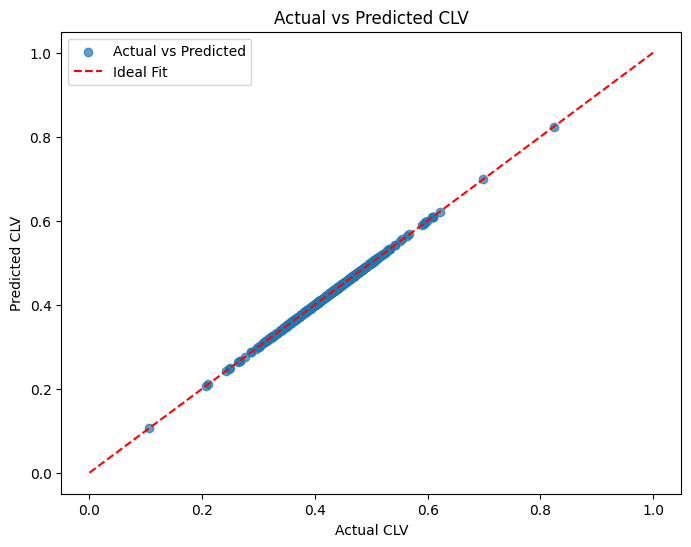

In [34]:
# 10. Result Visualization

# Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label="Actual vs Predicted")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Ideal Fit")
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted CLV")
plt.legend()
plt.show()


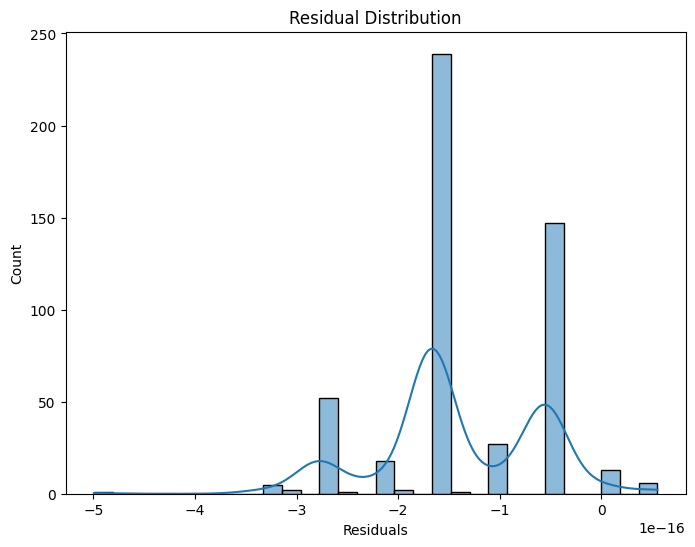

In [35]:
# Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.show()


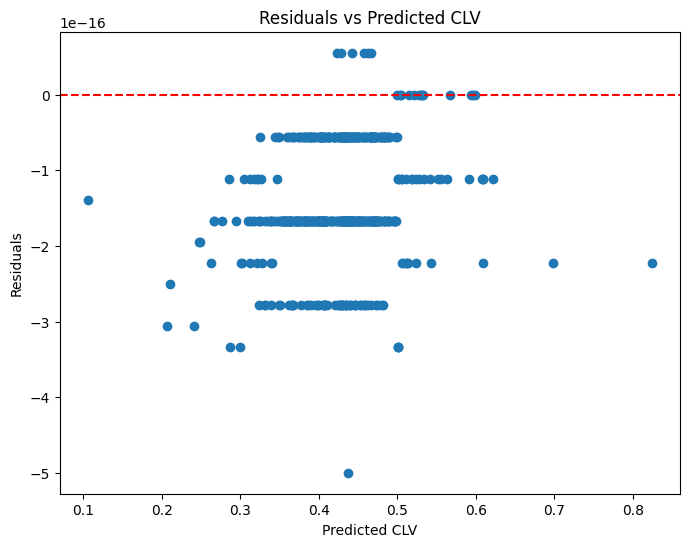

In [36]:
# Residuals vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted CLV")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted CLV")
plt.show()


<Figure size 800x600 with 0 Axes>

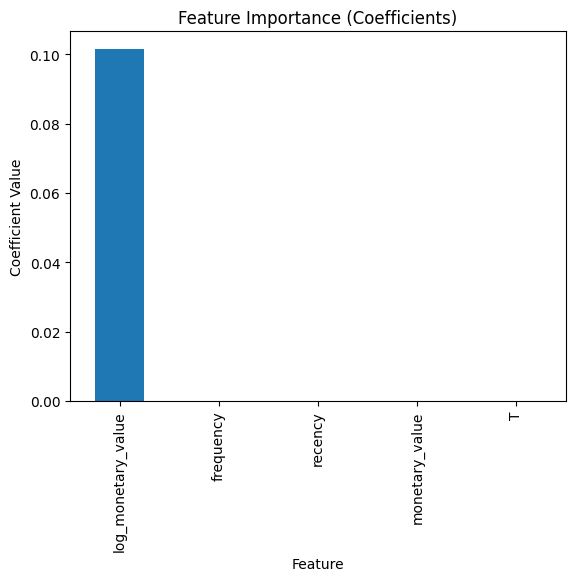

In [37]:
# Feature Importance Visualization (for coefficients)
plt.figure(figsize=(8, 6))
coefficients.sort_values(by="Coefficient", ascending=False).plot(kind='bar', legend=False)
plt.title("Feature Importance (Coefficients)")
plt.ylabel("Coefficient Value")
plt.xlabel("Feature")
plt.show()

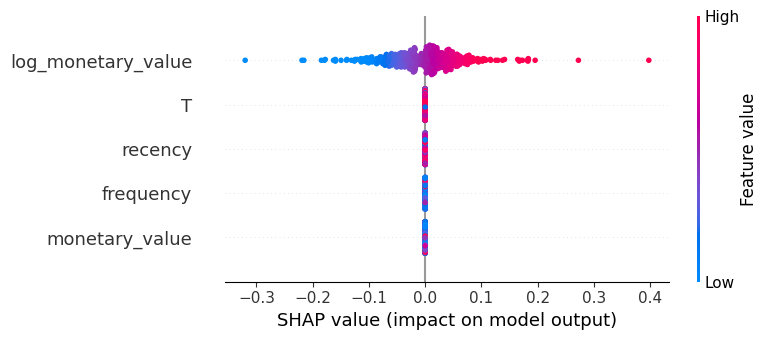

In [38]:
# 11. SHAP (SHapley Additive exPlanations) for Model Interpretability
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [39]:
# 12. Model Serialization
# Save the trained model using joblib
joblib.dump(model, 'cltv_model.pkl')
print("\nModel saved as cltv_model.pkl")



Model saved as cltv_model.pkl


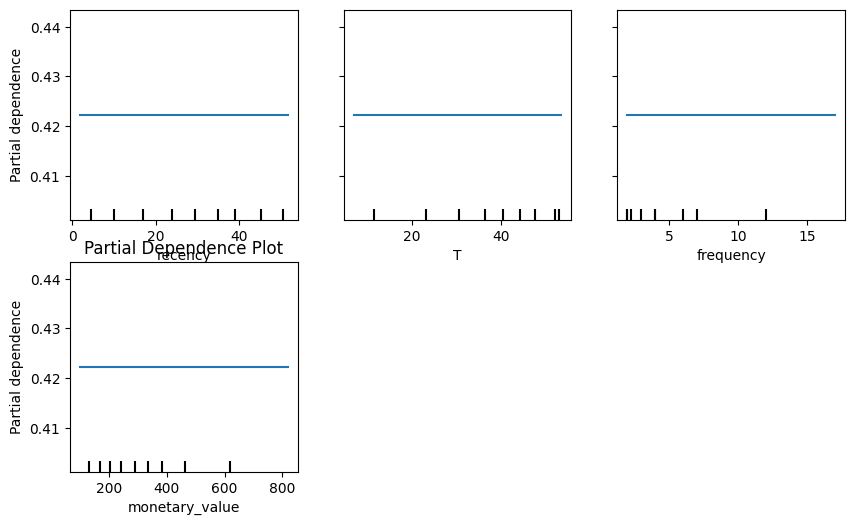

In [40]:
# 13. Partial Dependence Plots (Updated)
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(model, X_train, features=[0, 1, 2, 3], ax=ax, grid_resolution=50)
plt.title("Partial Dependence Plot")
plt.show()

In [41]:
# 14. Classification Metrics
# Define thresholds for classifying CLTV
low_threshold = 0.3
high_threshold = 0.7

# Create a new 'cltv_class' column based on the thresholds
cltv_df['cltv_class'] = pd.cut(cltv_df['scaled_clv'], bins=[-np.inf, low_threshold, high_threshold, np.inf],
                               labels=["Low", "Medium", "High"])

# Use the 'cltv_class' as the target variable
y = cltv_df['cltv_class']

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a classifier (Logistic Regression)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predict the classes
y_pred = classifier.predict(X_test)

# Classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.9941634241245136
Precision: 0.9922256809338522
Recall: 0.9941634241245136
F1 Score: 0.993193582687746


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
